# Copyright

<PRE>
Copyright (c) 2023 Bálint Gyires-Tóth - All Rights Reserved
You may use and modify this code for research and development purpuses.
Use this code for educational purposes (self-paced or instructor led) without the permission of the author is prohibited.
</PRE>

# Author classification
The task is to train a 1D CNN or an LSTM that is able to  classify text from two authors. The final model should be able to tell about a text with a given length (e.g. 60 characters) who wrote it. 

Please write the codes according to the following parts:

## Python module imports
Import all Python modules that you would need during the Assignment.

In [10]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import RMSprop
from urllib.request import urlretrieve
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

## Data acquisition
Seek a possible dataset, you can use any source, e.g.
* http://www.gutenberg.org/
* https://www.kaggle.com/datasets
* https://paperswithcode.com/datasets
* if you would like to learn Hungarian, than e.g. https://mek.oszk.hu/

You can download the text by hand (e.g. by copy-pasting some parts into txt files) or with Python. 

In [11]:
def get_text(text_link):
  urlretrieve(text_link, 'text.txt')
  text = open("text.txt", encoding='utf-8').read().lower()

  print('Number of characters in the text:', len(text))
  return (text)

In [12]:
dickens_link= "https://www.gutenberg.org/cache/epub/730/pg730.txt"
ibsen_link = "https://www.gutenberg.org/cache/epub/70684/pg70684.txt"

In [13]:
dickens= get_text(dickens_link)
ibsen = get_text(ibsen_link)

Number of characters in the text: 912335
Number of characters in the text: 458988


## Data analysis
Count the number of characters from both authors and display them on a plot (e.g. Seaborn's countplot).

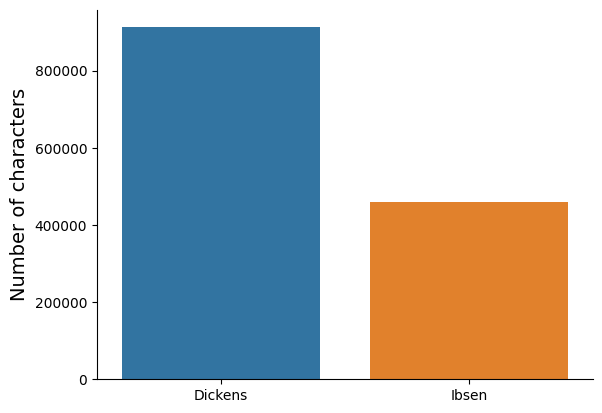

In [14]:
sns_plot = sns.barplot(x = np.array(['Dickens', 'Ibsen']),
                       y = np.array([len(dickens), len(ibsen)]))
sns_plot.set_ylabel('Number of characters', fontsize = 14)
sns_plot.spines['right'].set_visible(False)
sns_plot.spines['top'].set_visible(False)

## Data loading, labeling and preprocessing
Load the data and convert the characters into one-hot encodings. Then load the data into a 3D NumPy array, with a shape of

* (batch, sequence_length, alphabet_length)

where sequence_length=60, and alphabet_length equals to the number of unique characters in both datasets. The sequences should be cut out from the complete dataset by sliding window. You should add 0 and 1 labels to the sequences, according to the author. 

Later you may change sequence_length to achieve better results!

In [15]:
unique_chars = sorted(list(set(ibsen+dickens))) ## I have to difine one shared dictionary for the two authors to encode into one-hot by the same convention. 

In [16]:
def get_one_hot_array(text, maxlen = 60, label = None):

  maxlen  = maxlen
  step    = 10
  sentences  = [] 

  chars = unique_chars
  char_indices = dict((c, i) for i, c in enumerate(chars))
  for i in range(0, len(text)-maxlen, step):
      sentences.append(text[i:i+maxlen])

  ## Creating the training data
  X = np.zeros((len(sentences), maxlen, len(chars)))
  for i, sentence in enumerate(sentences): 
      for t, char in enumerate(sentence): 
          X[i,t,char_indices[char]] = 1 
    
  ## Assigning labels
  if label == 0:
    y = np.zeros((len(sentences)))
  else:
    y = np.ones((len(sentences)))

    
  return(X, y)

In [17]:
ibsen_X, ibsen_y = get_one_hot_array(ibsen, label = 0)
dickens_X, dickens_y = get_one_hot_array(dickens, label = 1)

In [18]:
print(dickens_X.shape, dickens_y.shape)
print(ibsen_X.shape, ibsen_y.shape)

(91228, 60, 75) (91228,)
(45893, 60, 75) (45893,)


In [19]:
## Sanity check 
## print(dickens_X[0,:,:].shape)
## np.where(dickens_X[0,:,:] != 0)[1].shape

In [20]:
## Free up some memory to avoid colab collaps
del ibsen
del dickens
del get_one_hot_array
del get_text
del urlretrieve
del unique_chars

In [21]:
## Concatenating the two arrays
X = np.concatenate((dickens_X, ibsen_X), axis=0)
y = np.concatenate((dickens_y, ibsen_y), axis=0)

In [22]:
print(X.shape[0] == dickens_X.shape[0] + ibsen_X.shape[0])
print(y.shape[0] == dickens_y.shape[0] + ibsen_y.shape[0])

True
True


In [23]:
## Free up some memory to avoid colab collaps
del dickens_X
del dickens_y
del ibsen_X
del ibsen_y

In [24]:
## Shuffling the data 
p = np.random.permutation(X.shape[0])
X_perm, y_perm = X[p], y[p]

In [25]:
## Sanity check 
##for i in range(5):
##  print(np.array_equal(X_perm[i,:,:], X[p[i], :,:]))

In [26]:
## returning to the standard naming convention 
X, y = X_perm, y_perm

In [27]:
print(np.array_equal(X, X_perm))
print(np.array_equal(y, y_perm))

True
True


In [28]:
## Free up some memory to avoid colab collaps
del X_perm
del y_perm

## Data splitting
Split the data into train, validate and test sets. Make 

In [29]:
split1 = int(X.shape[0]*0.7)
split2 = int(X.shape[0]*0.9)
print (split1, split2)

95984 123408


In [30]:
X_train = X[:split1]
y_train = y[:split1]

X_valid = X[split1:split2]
y_valid = y[split1:split2]

X_test  = X[split2:]
y_test  = y[split2:]

In [31]:
# Sanity check 
#X_train.shape[0] + X_valid.shape[0] +X_test.shape[0]

## Model definition
Define a 1D CNN or an LSTM for the task. Compile the model with the correct loss function.

In [32]:
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[-2], X_train.shape[-1])))
model.add(Dense(1, activation= 'sigmoid'))

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                35840     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 35,905
Trainable params: 35,905
Non-trainable params: 0
_________________________________________________________________


## Model training
Train the model and apply early stopping.

In [34]:
optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='binary_crossentropy', optimizer=optimizer,  metrics=['accuracy'])

In [35]:
es = keras.callbacks.EarlyStopping(patience = 6)
model.fit(X_train, y_train, 
                  validation_data=(X_valid,y_valid),
                  batch_size=1024,                             
                  epochs=40, 
                  verbose=1,
                  callbacks=es)

Epoch 1/40
94/94 [==============================] - 59s 606ms/step - loss: 0.5753 - accuracy: 0.7289 - val_loss: 0.5959 - val_accuracy: 0.7142
Epoch 2/40
94/94 [==============================] - 52s 550ms/step - loss: 0.5127 - accuracy: 0.7679 - val_loss: 0.3869 - val_accuracy: 0.8521
Epoch 3/40
94/94 [==============================] - 57s 607ms/step - loss: 0.3895 - accuracy: 0.8548 - val_loss: 0.3436 - val_accuracy: 0.8780
Epoch 4/40
94/94 [==============================] - 56s 596ms/step - loss: 0.4016 - accuracy: 0.8417 - val_loss: 0.3059 - val_accuracy: 0.8829
Epoch 5/40
94/94 [==============================] - 56s 596ms/step - loss: 0.3115 - accuracy: 0.8818 - val_loss: 0.3025 - val_accuracy: 0.8596
Epoch 6/40
94/94 [==============================] - 57s 606ms/step - loss: 0.2768 - accuracy: 0.8923 - val_loss: 0.2436 - val_accuracy: 0.9032
Epoch 7/40
94/94 [==============================] - 56s 594ms/step - loss: 0.2558 - accuracy: 0.8993 - val_loss: 0.2527 - val_accuracy: 0.8986

## Evaluation on test data
Evaluate the model on the test data in terms of loss and accuracy.

In [36]:
model.evaluate(X_test, y_test)

429/429 [==============================] - 7s 17ms/step - loss: 0.1276 - accuracy: 0.9558


[0.12761418521404266, 0.9558083415031433]

## Confusion matrix
Calculate and display the confusion matrix.

In [37]:
predictions = (model.predict(X_test) > 0.5).astype("int32")

429/429 [==============================] - 7s 16ms/step


In [38]:
#print(np.count_nonzero(y_test == 1))
## 8712+427

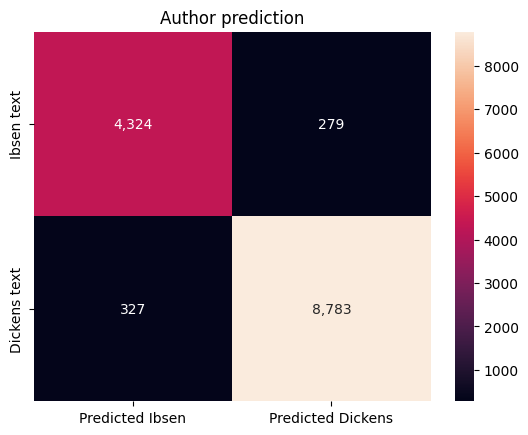

In [39]:
conf = confusion_matrix(y_test, predictions)
sns_plot = sns.heatmap(conf, annot=True, fmt=',d')
sns_plot.set_yticklabels(['Ibsen text', 'Dickens text'])
sns_plot.set_xticklabels(['Predicted Ibsen', 'Predicted Dickens'])
sns_plot.set_title('Author prediction');